<a href="https://colab.research.google.com/github/lorenz0leoncin1/tree-predictors-mushroom-classification/blob/main/Tree_predictors_for_binary_classification_mushrooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 1: Import libraries & dataset

In [228]:
# Install necessary packages
!pip3 install -U ucimlrepo
!pip3 install -U scikit-learn

import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

In [229]:
# fetch dataset
secondary_mushroom = fetch_ucirepo(id=848)

# data (as pandas dataframes)
X = secondary_mushroom.data.features
y = secondary_mushroom.data.targets

In [230]:
X.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


In [231]:
y.head()

,class
0,p
1,p
2,p
3,p
4,p


In [232]:
print(X.shape)
print(y.shape)

(61069, 20)
(61069, 1)


# Phase 2: Data pre-processing

In [233]:
# Check for missing values
missing_values = X.isnull().sum()
print("Missing values per feature:\n", missing_values)

Missing values per feature:
 cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64


In [234]:
# Threshold for dropping columns with too many missing values (e.g., more than 50%)
threshold = 0.5 * len(X)  # 50% of total rows
X_dropped = X.drop(columns=[col for col in X.columns if X[col].isnull().sum() > threshold])
print("Dataset after removing columns with too many missing values:\n", X_dropped.head())

Dataset after removing columns with too many missing values:
    cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0         15.26         x           g         o                    f   
1         16.60         x           g         o                    f   
2         14.07         x           g         o                    f   
3         14.17         f           h         e                    f   
4         14.64         x           h         o                    f   

  gill-attachment gill-spacing gill-color  stem-height  stem-width stem-color  \
0               e          NaN          w        16.95       17.09          w   
1               e          NaN          w        17.99       18.19          w   
2               e          NaN          w        17.80       17.74          w   
3               e          NaN          w        15.77       15.98          w   
4               e          NaN          w        16.53       17.20          w   

  has-ring ring-ty

In [235]:
# Controllo dei valori mancanti nel nuovo DataFrame
missing_values_dropped = X_dropped.isnull().sum()
print("Missing values per feature dopo la rimozione delle colonne:\n", missing_values_dropped)

# Visualizzazione dei tipi di dato delle colonne
print("Tipi di dato delle colonne:\n", X_dropped.dtypes)


Missing values per feature dopo la rimozione delle colonne:
 cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-color                  0
has-ring                    0
ring-type                2471
habitat                     0
season                      0
dtype: int64
Tipi di dato delle colonne:
 cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-color               object
has-ring                 object
ring-type                object
habitat                  object

In [236]:
# Visualizzazione delle prime righe del DataFrame finale
print("Prime righe del DataFrame finale:\n", X_dropped.head())


Prime righe del DataFrame finale:
    cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0         15.26         x           g         o                    f   
1         16.60         x           g         o                    f   
2         14.07         x           g         o                    f   
3         14.17         f           h         e                    f   
4         14.64         x           h         o                    f   

  gill-attachment gill-spacing gill-color  stem-height  stem-width stem-color  \
0               e          NaN          w        16.95       17.09          w   
1               e          NaN          w        17.99       18.19          w   
2               e          NaN          w        17.80       17.74          w   
3               e          NaN          w        15.77       15.98          w   
4               e          NaN          w        16.53       17.20          w   

  has-ring ring-type habitat season  
0      

In [237]:
# Fill missing values in object-type columns with 'unknown'
object_cols = X_dropped.select_dtypes(include=['object']).columns
X_dropped[object_cols] = X_dropped[object_cols].fillna('unknown')

# Check the result
missing_values_after_fill = X_dropped.isnull().sum()
print("Missing values after filling:\n", missing_values_after_fill)


Missing values after filling:
 cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64


In [238]:
# Define categorical and numerical columns
categorical_cols = X_dropped.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_dropped.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),  # Keep numerical columns as is
        ('cat', OneHotEncoder(), categorical_cols)  # Apply OneHotEncoding to categorical columns
    ]
)

# Create the pipeline with the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())  # Use the desired classifier
])


# Phase 3: Division dataset in Trainin & Test sets & Results

In [249]:
X_dropped.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,15.26,x,g,o,f,e,unknown,w,16.95,17.09,w,t,g,d,w
1,16.60,x,g,o,f,e,unknown,w,17.99,18.19,w,t,g,d,u
2,14.07,x,g,o,f,e,unknown,w,17.80,17.74,w,t,g,d,w
3,14.17,f,h,e,f,e,unknown,w,15.77,15.98,w,t,p,d,w
4,14.64,x,h,o,f,e,unknown,w,16.53,17.20,w,t,p,d,w


In [250]:
X_dropped.shape

(61069, 15)

In [251]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.25, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9971836520827875
Classification Report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00      6781
           p       1.00      1.00      1.00      8487

    accuracy                           1.00     15268
   macro avg       1.00      1.00      1.00     15268
weighted avg       1.00      1.00      1.00     15268

Confusion Matrix:
 [[6769   12]
 [  31 8456]]


In [252]:
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (45801, 15)
Test set size: (15268, 15)


#Phase 4: Cross-Validation & Analysis

In [253]:
# Convert y_train to a 1D array
y_train = y_train.values.ravel()


In [254]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", cv_scores.mean())


Cross-Validation Scores: [0.99727104 0.99683406 0.99727074 0.99770742 0.99803493]
Average CV Score: 0.9974236403702996


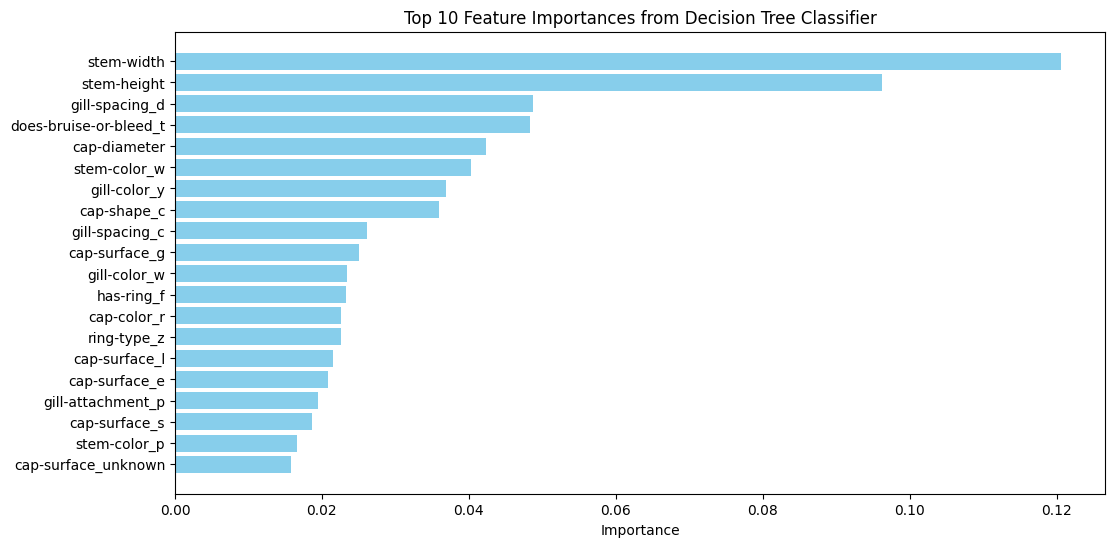

In [255]:
# Feature Importances Analysis
# Extract the model from the pipeline
model = pipeline.named_steps['classifier']

# Get the feature importances
importances = model.feature_importances_

# Get the feature names
feature_names = numerical_cols + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))

# Create a DataFrame for the importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the importances
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Select the top 10 most important features
top_10_features = feature_importances.head(20)

# Visualize the top 10 importances
plt.figure(figsize=(12, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances from Decision Tree Classifier')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important features at the top
plt.show()
